# Balloon/Satellite Detection of HNL Decays

This notebook calculates the sensitivity of a balloon/satellite detector to Heavy Neutral Lepton (HNL) decays.

**Setup:**
- Muon beam travels upward through Earth toward a satellite/balloon detector
- HNLs are produced when muons scatter off nucleons in a target region below the surface
- HNLs travel upward and decay in the atmosphere
- Cherenkov light from decay products (muons) is detected by the satellite

**Sections:**
1. Setup and imports
2. Cherenkov photon detection verification
3. HNL flux geometry and signal calculation
4. Sensitivity estimation

## 1. Setup and Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import os

plt.style.use("figures.mplstyle")

from src.constants import *
from src.xs_and_decays import *
from src.balloon import *
from src.cherenkov import (
    cherenkov_photons_detected_vectorized,
    get_cherenkov_angle,
    get_cherenkov_yield_per_meter,
    CherenkovLookupTable
)

# Beam parameters
E_mu = 5000  # GeV - muon beam energy
E_N = E_mu / 2  # Approximate HNL energy

print(f"Muon beam energy: {E_mu} GeV")
print(f"Detector altitude: {L_det/1000:.0f} km")
print(f"Detector radius: {R_det} m")
print(f"Cherenkov angle: {np.degrees(theta_C):.4f} deg")
print(f"Cherenkov yield: {Ch_dN_dx:.2f} photons/m")

Muon beam energy: 5000 GeV
Detector altitude: 33 km
Detector radius: 2 m
Cherenkov angle: 1.4033 deg
Cherenkov yield: 64.18 photons/m


## 2. Cherenkov Photon Detection

Verify the Cherenkov photon calculation for different particle configurations.

Computing photon map...
  10/30 complete
  20/30 complete
  30/30 complete
Done!


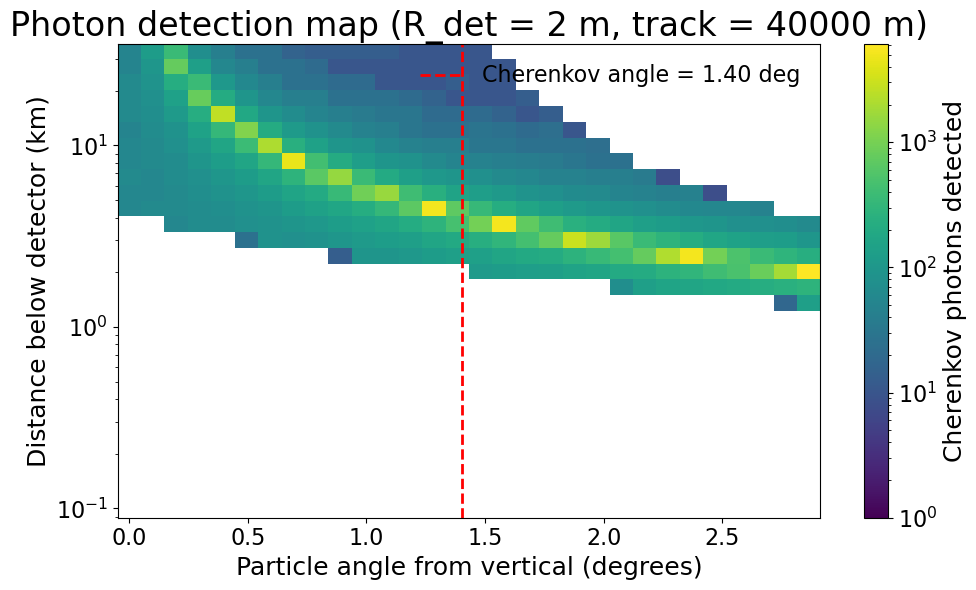

In [24]:
# Create a 2D map: photon count as function of (z, theta)
z_range_map = np.logspace(2, np.log10(L_det), 30)  # 100 m to detector altitude
theta_range_map = np.linspace(0, 0.05, 30)  # 0 to ~3 degrees
track_length = 40000  # m

N_photons_map = np.zeros((len(z_range_map), len(theta_range_map)))

print("Computing photon map...")
for iz, z in enumerate(z_range_map):
    for ith, theta in enumerate(theta_range_map):
        r_0 = np.array([-100, 0, -z])
        p_hat = np.array([np.sin(theta), 0, np.cos(theta)])
        N_photons_map[iz, ith], _, _ = cherenkov_photons_detected_vectorized(
            r_0, p_hat, track_length, R_det, N_psi=1000, N_track=1000
        )
    if (iz + 1) % 10 == 0:
        print(f"  {iz+1}/{len(z_range_map)} complete")

print("Done!")

# Plot
theta_mesh, z_mesh = np.meshgrid(np.degrees(theta_range_map), z_range_map/1000)

plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(theta_mesh, z_mesh, N_photons_map,
                      norm=LogNorm(vmin=1, vmax=N_photons_map.max()),
                      shading='auto', cmap='viridis')
plt.axvline(np.degrees(theta_C), color='r', linestyle='--', linewidth=2,
            label=f'Cherenkov angle = {np.degrees(theta_C):.2f} deg')
plt.colorbar(pcm, label='Cherenkov photons detected')
plt.xlabel('Particle angle from vertical (degrees)')
plt.ylabel('Distance below detector (km)')
plt.yscale('log')
plt.title(f'Photon detection map (R_det = {R_det} m, track = {track_length} m)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("Figures/balloon/cherenkov_photon_map.png", dpi=300)
plt.show()

## 3. HNL Flux Geometry and Signal Calculation

Set up the full HNL production and detection geometry, accounting for:
- Angular spread from HNL production
- HNL decay kinematics
- Realistic muon track lengths in atmosphere

In [25]:
# Create default flux geometry
flux_geometry = HNLFluxGeometry(
    E_mu=E_mu,
    beam_offset_angle=0.0,  # Beam aimed directly at detector
    target_depth=200,       # 200 m below surface
    satellite_height=10000  # 10 km altitude
)

print("HNL Flux Geometry Configuration")
print("=" * 40)
print(f"Muon beam energy: {flux_geometry.E_mu} GeV")
print(f"Beam direction: {flux_geometry.beam_dir}")
print(f"Target depth: {flux_geometry.target_depth} m")
print(f"Target length: {flux_geometry.L_target} m")
print(f"Satellite height: {flux_geometry.satellite_height/1000:.1f} km")

HNL Flux Geometry Configuration
Muon beam energy: 5000 GeV
Beam direction: [0. 0. 1.]
Target depth: 200 m
Target length: 400 m
Satellite height: 10.0 km


In [26]:
# Test signal calculation for a single HNL configuration
m_N_test = 20  # GeV
U2_test = 1e-12

print(f"Testing signal calculation for m_N = {m_N_test} GeV, U2 = {U2_test:.0e}")
print("-" * 50)

det_eff, mean_photons, n_events = compute_signal_at_satellite(
    m_N_test, E_mu, U2_test, flux_geometry, N_samples=2000
)

print(f"Detection efficiency: {det_eff:.4f}")
print(f"Mean photons (detected events): {mean_photons:.1f}")
print(f"Expected events (N_muon = {N_muon_decays:.0e}): {n_events:.2f}")

Testing signal calculation for m_N = 20 GeV, U2 = 1e-12
--------------------------------------------------
Detection efficiency: 0.0005
Mean photons (detected events): 800.2
Expected events (N_muon = 1e+22): 3.03


## 4. Sensitivity Estimation

Scan over HNL mass and mixing angle to estimate detector sensitivity.

In [27]:
def compute_sensitivity_scan(flux_geometry, m_N_range, U2_range,
                              N_samples=1000, min_photons=10, verbose=True):
    """
    Scan over HNL mass and mixing angle to compute expected event rates.

    Parameters
    ----------
    flux_geometry : HNLFluxGeometry
        The flux geometry configuration
    m_N_range : array
        HNL masses to scan [GeV]
    U2_range : array
        Mixing angles squared to scan
    N_samples : int
        Number of Monte Carlo samples per point
    min_photons : int
        Minimum photons for detection
    verbose : bool
        Print progress

    Returns
    -------
    results : dict
        Dictionary with 'events', 'efficiency', 'mean_photons' arrays
    """
    n_m = len(m_N_range)
    n_U2 = len(U2_range)

    events = np.zeros((n_U2, n_m))
    efficiency = np.zeros((n_U2, n_m))
    mean_photons = np.zeros((n_U2, n_m))

    total = n_m * n_U2
    count = 0

    for im, m_N in enumerate(m_N_range):
        if verbose:
            print(f"Scanning m_N = {m_N:.2f} GeV ({im+1}/{n_m})")

        for iU2, U2 in enumerate(U2_range):
            try:
                eff, mph, n_ev = compute_signal_at_satellite(
                    m_N, flux_geometry.E_mu, U2, flux_geometry,
                    N_samples=N_samples, min_photons=min_photons
                )
                events[iU2, im] = n_ev
                efficiency[iU2, im] = eff
                mean_photons[iU2, im] = mph
            except Exception as e:
                if verbose:
                    print(f"  Warning: Failed for U2={U2:.0e}: {e}")
                events[iU2, im] = 0
                efficiency[iU2, im] = 0
                mean_photons[iU2, im] = 0

            count += 1

    return {
        'm_N': m_N_range,
        'U2': U2_range,
        'events': events,
        'efficiency': efficiency,
        'mean_photons': mean_photons
    }


def find_sensitivity_contour(results, n_events_threshold=3):
    """
    Find the sensitivity contour (U2 vs m_N) for a given event threshold.

    Parameters
    ----------
    results : dict
        Output from compute_sensitivity_scan
    n_events_threshold : float
        Number of events for sensitivity (default 3 for 95% CL)

    Returns
    -------
    m_N_contour, U2_contour : arrays
        Mass and mixing angle values along the contour
    """
    m_N_range = results['m_N']
    U2_range = results['U2']
    events = results['events']

    m_N_contour = []
    U2_contour = []

    for im, m_N in enumerate(m_N_range):
        # Find U2 where events crosses threshold
        ev_col = events[:, im]

        # Find first U2 where we get enough events
        above_threshold = ev_col >= n_events_threshold
        if np.any(above_threshold):
            idx = np.where(above_threshold)[0][-1]  # Largest U2 below threshold
            if idx < len(U2_range) - 1:
                # Interpolate
                U2_sens = np.interp(n_events_threshold,
                                    [ev_col[idx+1], ev_col[idx]],
                                    [U2_range[idx+1], U2_range[idx]])
            else:
                U2_sens = U2_range[idx]
            m_N_contour.append(m_N)
            U2_contour.append(U2_sens)

    return np.array(m_N_contour), np.array(U2_contour)


def plot_sensitivity(results, title=None, save_path=None):
    """
    Plot sensitivity contours from scan results.

    Parameters
    ----------
    results : dict
        Output from compute_sensitivity_scan
    title : str, optional
        Plot title
    save_path : str, optional
        Path to save figure
    """
    m_N_range = results['m_N']
    U2_range = results['U2']
    events = results['events']

    m_N_mesh, U2_mesh = np.meshgrid(m_N_range, U2_range)

    fig, ax = plt.subplots(figsize=(10, 7))

    # Contour levels
    levels = [1, 10, 100, 1000]
    colors = ['red', 'orange', 'green', 'blue']

    for level, color in zip(levels, colors):
        cs = ax.contour(m_N_mesh, U2_mesh, events, levels=[level],
                        colors=[color], linewidths=2)
        ax.clabel(cs, fmt=f'{level:.0f} events', fontsize=10)

    # Seesaw bound
    U2_seesaw = 5e-11 / m_N_range
    ax.fill_between(m_N_range, 1e-20, U2_seesaw, color='gray', alpha=0.2)
    ax.plot(m_N_range, U2_seesaw, 'gray', linestyle='--', label='Seesaw bound')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'HNL Mass $m_N$ [GeV]')
    ax.set_ylabel(r'$|U_\mu|^2$')
    ax.set_xlim(m_N_range[0], m_N_range[-1])
    ax.set_ylim(U2_range[0], U2_range[-1])
    ax.legend(loc='lower left')

    if title:
        ax.set_title(title)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

    return fig, ax

In [28]:
# Run sensitivity scan
m_N_scan = np.logspace(0, 2, 30)  # 1 to ~100 GeV
U2_scan = np.logspace(-14, -8, 30)  # Wide range of mixing angles

print("Running sensitivity scan...")
print(f"Mass range: {m_N_scan[0]:.1f} - {m_N_scan[-1]:.1f} GeV")
print(f"U2 range: {U2_scan[-1]:.0e} - {U2_scan[0]:.0e}")
print()

results = compute_sensitivity_scan(
    flux_geometry, m_N_scan, U2_scan,
    N_samples=100000, min_photons=5, verbose=True
)

print("\nScan complete!")

Running sensitivity scan...
Mass range: 1.0 - 100.0 GeV
U2 range: 1e-08 - 1e-14

Scanning m_N = 1.00 GeV (1/30)
Scanning m_N = 1.17 GeV (2/30)
Scanning m_N = 1.37 GeV (3/30)
Scanning m_N = 1.61 GeV (4/30)
Scanning m_N = 1.89 GeV (5/30)
Scanning m_N = 2.21 GeV (6/30)
Scanning m_N = 2.59 GeV (7/30)
Scanning m_N = 3.04 GeV (8/30)
Scanning m_N = 3.56 GeV (9/30)
Scanning m_N = 4.18 GeV (10/30)
Scanning m_N = 4.89 GeV (11/30)
Scanning m_N = 5.74 GeV (12/30)
Scanning m_N = 6.72 GeV (13/30)
Scanning m_N = 7.88 GeV (14/30)
Scanning m_N = 9.24 GeV (15/30)
Scanning m_N = 10.83 GeV (16/30)
Scanning m_N = 12.69 GeV (17/30)
Scanning m_N = 14.87 GeV (18/30)
Scanning m_N = 17.43 GeV (19/30)
Scanning m_N = 20.43 GeV (20/30)
Scanning m_N = 23.95 GeV (21/30)
Scanning m_N = 28.07 GeV (22/30)
Scanning m_N = 32.90 GeV (23/30)
Scanning m_N = 38.57 GeV (24/30)
Scanning m_N = 45.20 GeV (25/30)
Scanning m_N = 52.98 GeV (26/30)
Scanning m_N = 62.10 GeV (27/30)
Scanning m_N = 72.79 GeV (28/30)
Scanning m_N = 85.3

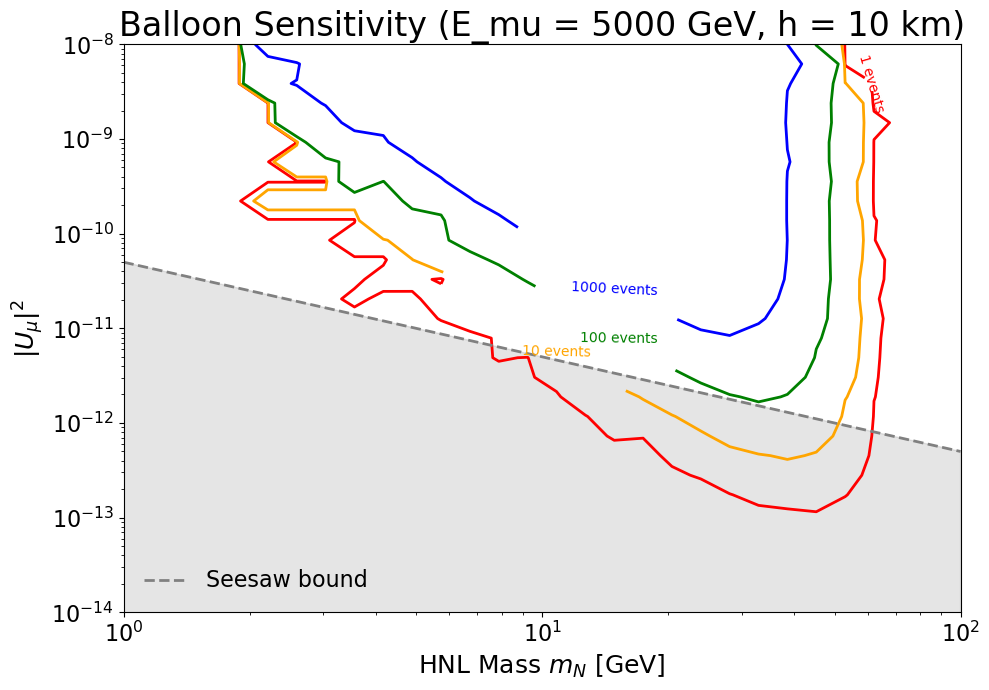

(<Figure size 1000x700 with 1 Axes>,
 <Axes: title={'center': 'Balloon Sensitivity (E_mu = 5000 GeV, h = 10 km)'}, xlabel='HNL Mass $m_N$ [GeV]', ylabel='$|U_\\mu|^2$'>)

In [34]:
# Plot sensitivity results
plot_sensitivity(
    results,
    title=f'Balloon Sensitivity (E_mu = {E_mu} GeV, h = {10e3/1000:.0f} km)',
    save_path='Figures/balloon/sensitivity_scan.png'
)

## 5. Parameter Studies

Explore how sensitivity depends on experimental parameters.

In [30]:
# Study sensitivity vs satellite height
heights = [10e3, 20e3, 33e3, 50e3]  # km
m_N_test = 40  # GeV
U2_test = 1e-12

print("Scanning satellite heights...")
print(f"Test point: m_N = {m_N_test} GeV, U2 = {U2_test:.0e}")
print("-" * 50)

for h in heights:
    geom = HNLFluxGeometry(
        E_mu=E_mu,
        beam_offset_angle=0.0,
        target_depth=200,
        satellite_height=h
    )

    eff, mph, n_ev = compute_signal_at_satellite(
        m_N_test, E_mu, U2_test, geom, N_samples=10000
    )

    print(f"h = {h/1000:.0f} km: efficiency = {eff:.4f}, events = {n_ev:.1f}")

Scanning satellite heights...
Test point: m_N = 40 GeV, U2 = 1e-12
--------------------------------------------------
h = 10 km: efficiency = 0.0270, events = 38.9
h = 20 km: efficiency = 0.0202, events = 29.1
h = 33 km: efficiency = 0.0111, events = 16.0
h = 50 km: efficiency = 0.0039, events = 5.6


In [31]:
# Study sensitivity vs target depth
depths = [50, 100, 200, 500]  # m

print("Scanning target depths...")
print(f"Test point: m_N = {m_N_test} GeV, U2 = {U2_test:.0e}")
print("-" * 50)

for d in depths:
    geom = HNLFluxGeometry(
        E_mu=E_mu,
        beam_offset_angle=0.0,
        target_depth=d,
        satellite_height=L_det
    )

    eff, mph, n_ev = compute_signal_at_satellite(
        m_N_test, E_mu, U2_test, geom, N_samples=10000
    )

    print(f"depth = {d} m: efficiency = {eff:.4f}, events = {n_ev:.1f}")

Scanning target depths...
Test point: m_N = 40 GeV, U2 = 1e-12
--------------------------------------------------
depth = 50 m: efficiency = 0.0115, events = 4.1
depth = 100 m: efficiency = 0.0102, events = 7.4
depth = 200 m: efficiency = 0.0104, events = 15.0
depth = 500 m: efficiency = 0.0111, events = 40.0
